## Import necessary packages

In [1]:
import os, sys
import colorsys
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from imageio import imread
from ugscnn.loader import S2D3DSegLoader
from cnns.loader import SemSegLoader

## Helper functions to show the mask image

In [2]:
def apply_mask(image, label, colors):
    N = len(colors)
    for i in range(N):
        index = (label==i)
        image[index] = colors[i]
    return image

def show_mask(image, label, colors):
    image = apply_mask(image, label, colors)
    show(image)
    
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def show(image):
    plt.figure(figsize=(12,8))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# 2d3ds Dataset
Read image from graviti directly

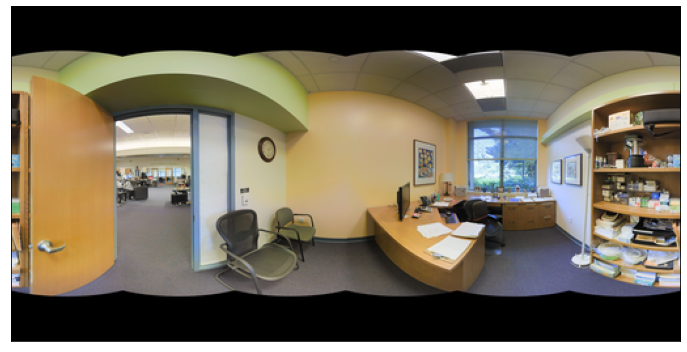

In [10]:
from cnns.loader import pano_data
from cnns.loader import read_gas_image
rgb = read_gas_image(pano_data["rgb"][0])
show(rgb)

The processed dataset using `SemSegLoader`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


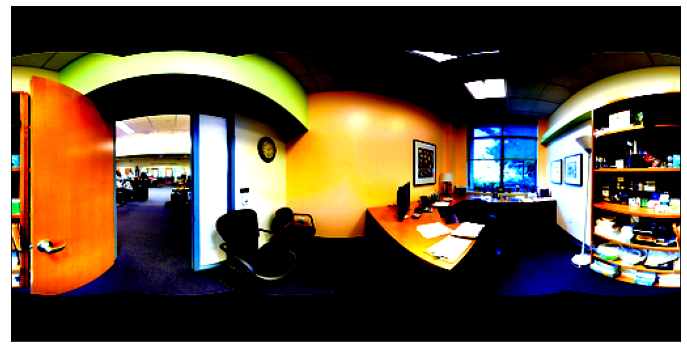

In [12]:
segloader = SemSegLoader(partition="train", fold=1,)
rgb, mask = segloader[0][0], segloader[0][1]
rgb = np.einsum("ijk->jki", rgb)[:,:,:3]
show(rgb)

In [13]:
N = 13
colors = random_colors(N)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


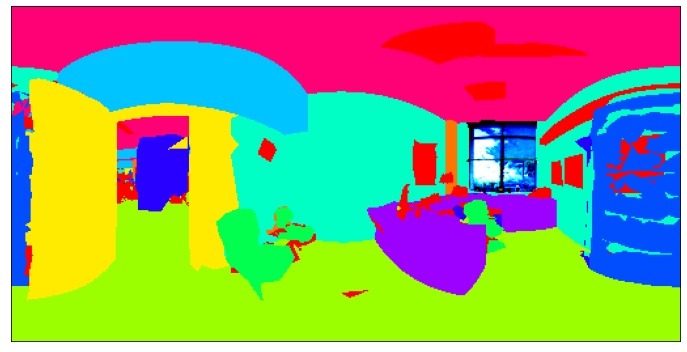

In [14]:
show_mask(rgb, mask, colors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1152x648 with 0 Axes>

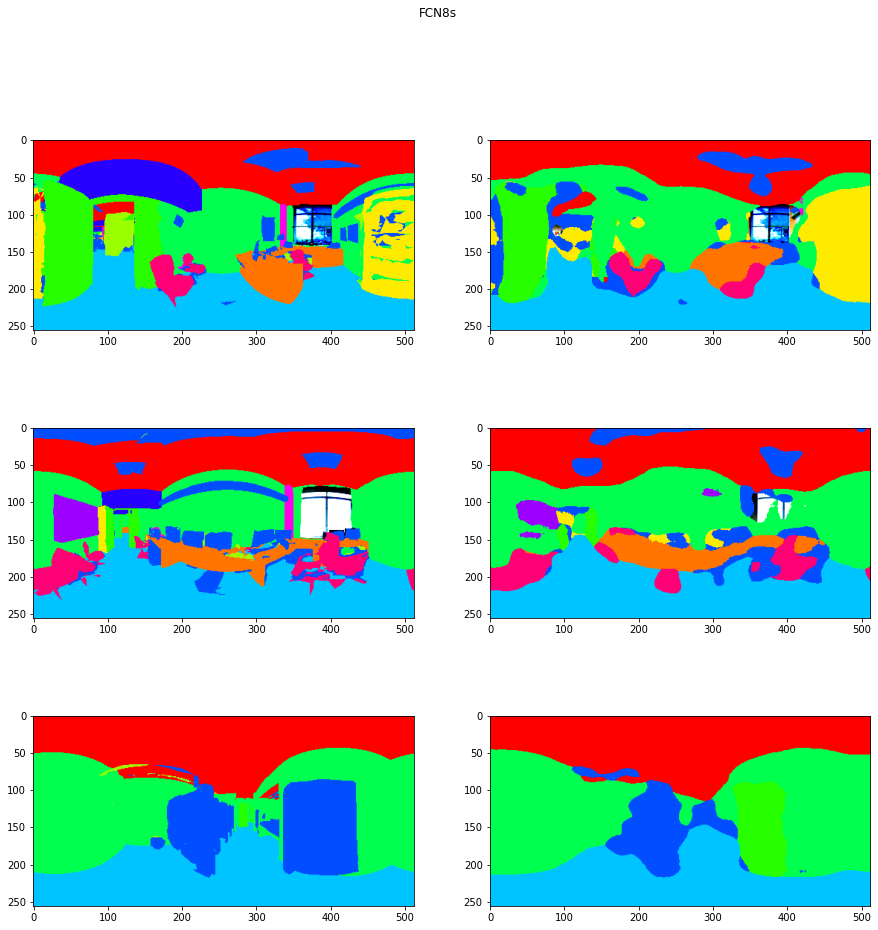

In [9]:
samples = np.load("cnns/samples.npz")

def show_result(samples, Nsamples = 3, title=None):
    plt.figure(figsize=(16,9))
    fig, axs = plt.subplots(Nsamples, 2)
    fig.suptitle(title)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(Nsamples):
        image = samples["data"][i]
        image = np.einsum("ijk->jki", image)[:,:,:3]
        mask = samples["labels"][i]
        predict = samples["predict"][i]
        ground_truth = apply_mask(image.copy(), mask, colors)
        predict_label = apply_mask(image.copy(), predict, colors)
        
        axs[i,0].imshow(ground_truth)
        axs[i,1].imshow(predict_label)
    plt.show()
show_result(samples, title="FCN8s")